# Explore and Understand the data

In [1]:

import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [2]:
dataset_dir= r"/content/drive/MyDrive/TrashType_Image_Dataset"
image_size = (224, 224)
batch_size = 32
seed = 42

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [4]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [5]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [6]:

print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


# Visualize sample images from each class.

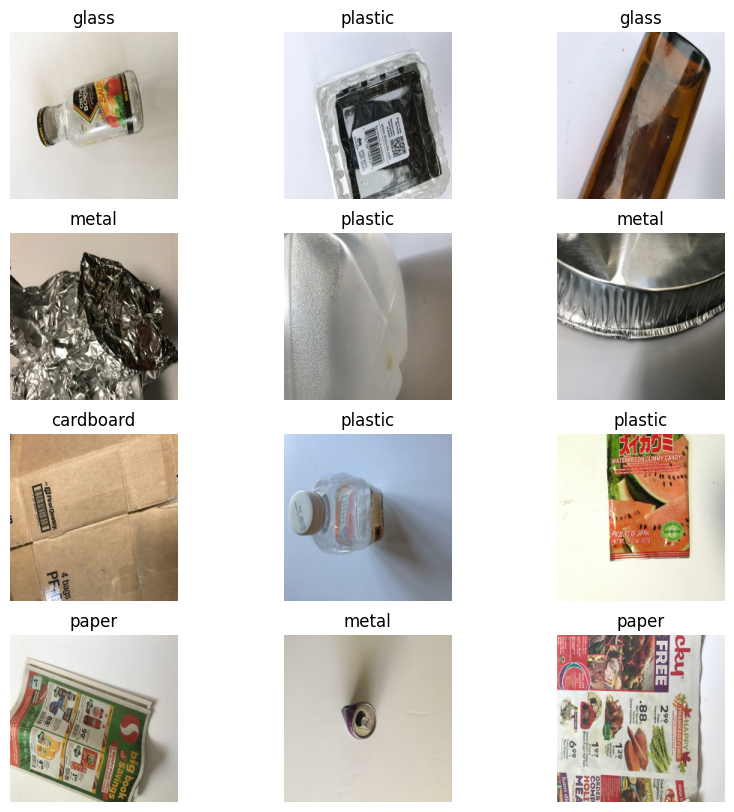

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# Ensure balanced classes &
# Understand Image properties

In [8]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts



In [9]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [10]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


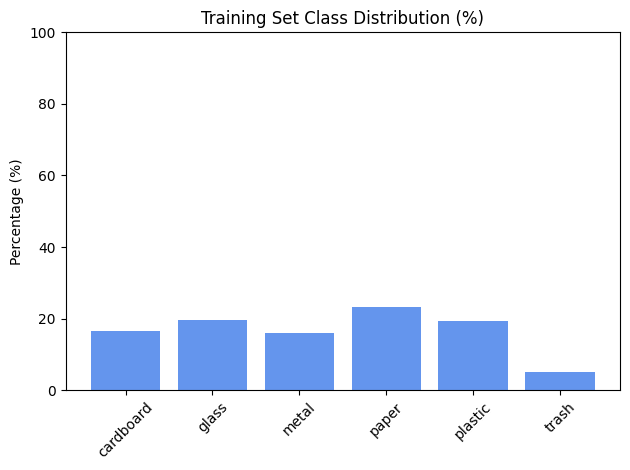

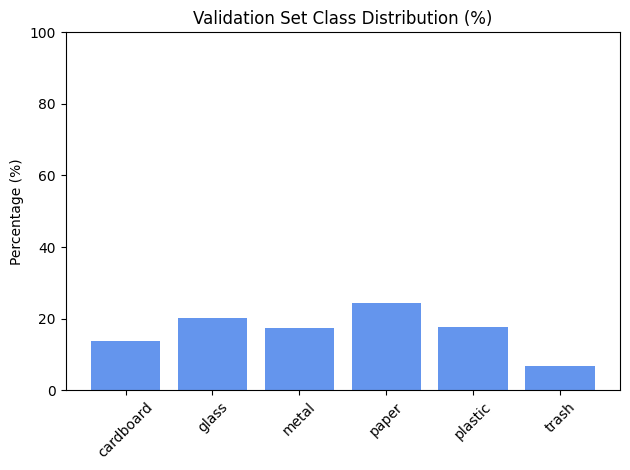

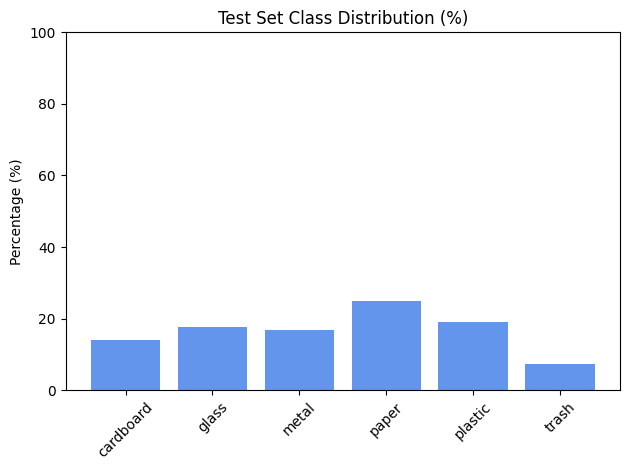

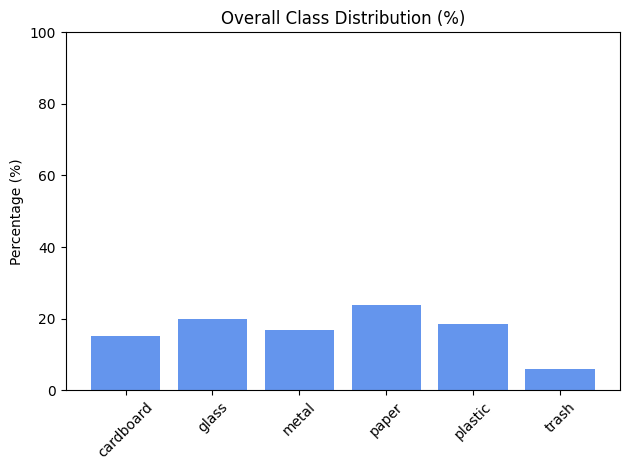

In [11]:

# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

# Balancing classes

In [12]:


# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [13]:

# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


# Data Preprocessing / Preparation

In [14]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Model Selection

In [15]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(224, 224, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False



35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Model Training
# Model Tuning & Optimization

In [16]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])


In [17]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


CALLBACKS

In [18]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


In [19]:
# Set the number of epochs to train the model
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 371ms/step - accuracy: 0.3705 - loss: 1.6258 - val_accuracy: 0.6990 - val_loss: 0.9824
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 275ms/step - accuracy: 0.7625 - loss: 0.9193 - val_accuracy: 0.8079 - val_loss: 0.5926
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - accuracy: 0.8582 - loss: 0.5011 - val_accuracy: 0.8693 - val_loss: 0.3895
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 275ms/step - accuracy: 0.9037 - loss: 0.3160 - val_accuracy: 0.8990 - val_loss: 0.3314
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.9407 - loss: 0.2161 - val_accuracy: 0.9109 - val_loss: 0.2997
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 278ms/step - accuracy: 0.9387 - loss: 0.1701 - val_accuracy: 0.9188 - val_loss: 0.2715
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - accuracy: 0.9662 - loss: 0.1093 - val_accuracy: 0.9149 - val_loss: 0.2757
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.9679 - loss: 0.1066 - val_accu

In [20]:
# 📝 Summary (optional but useful)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [21]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

# Model Performance Visualization

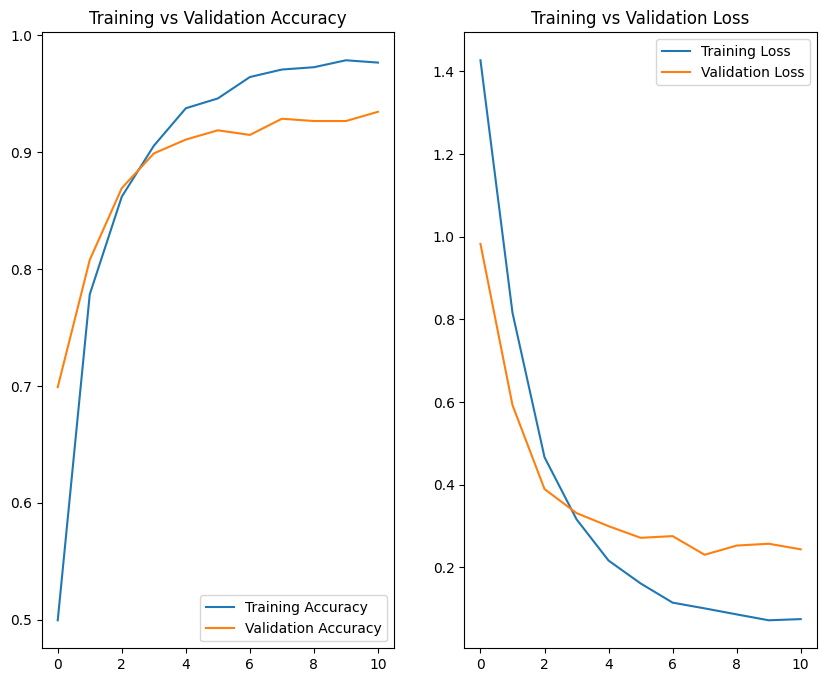

In [22]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

# Model Evaluation

In [23]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9347 - loss: 0.1795
Test accuracy is0.9414, Test loss is 0.1762


In [24]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step
[[32  0  0  4  0  0]
 [ 0 44  1  0  5  0]
 [ 0  0 43  0  0  0]
 [ 1  0  1 63  0  1]
 [ 0  0  0  0 43  0]
 [ 0  0  2  0  0 16]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       1.00      0.88      0.94        50
           2       0.91      1.00      0.96        43
           3       0.94      0.95      0.95        66
           4       0.90      1.00      0.95        43
           5       0.94      0.89      0.91        18

    accuracy                           0.94       256
   macro avg       0.94      0.94      0.94       256
weighted avg       0.94      0.94      0.94       256



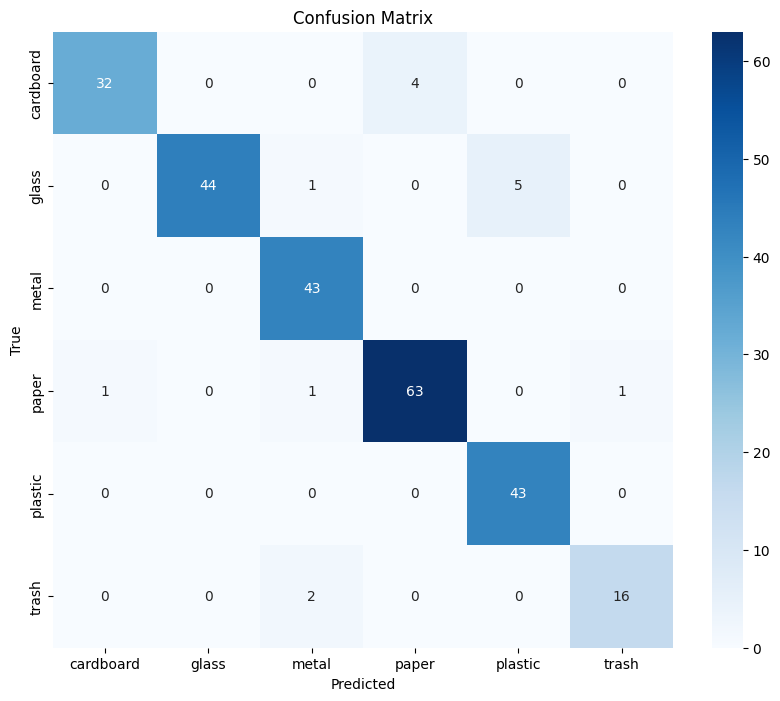

In [25]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

# Testing and Save the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


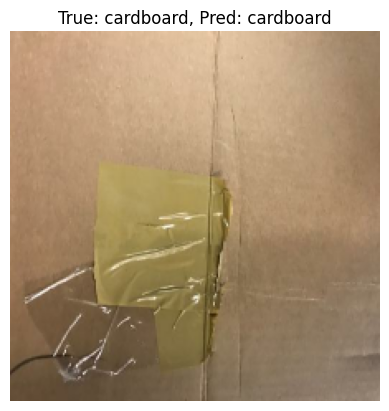

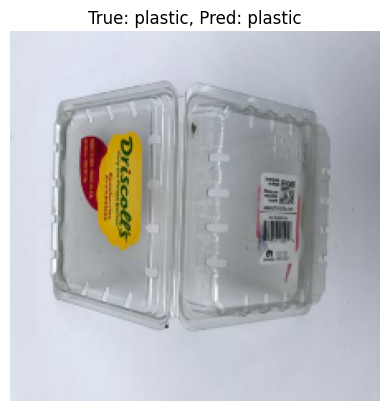

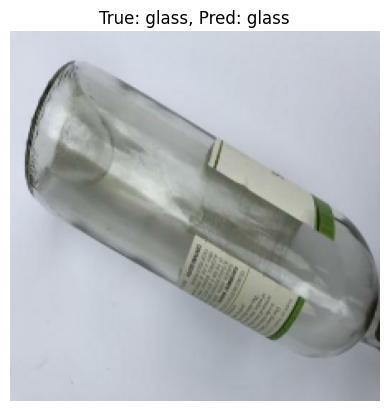

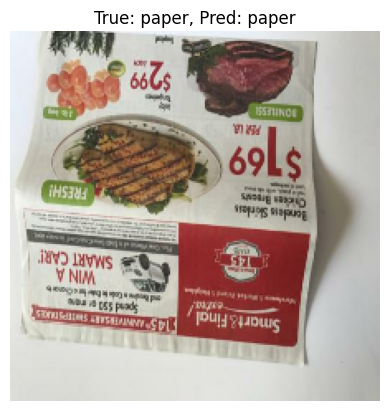

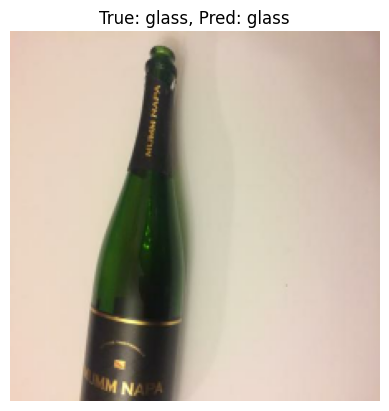

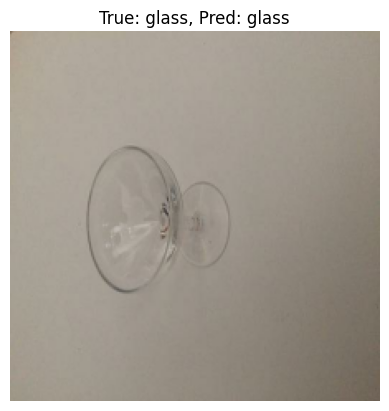

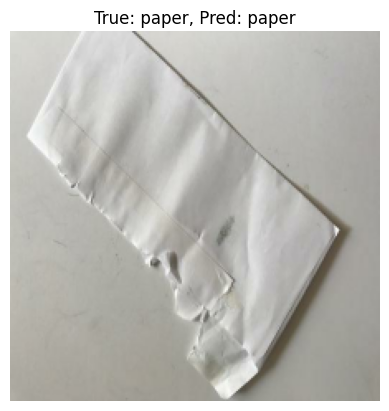

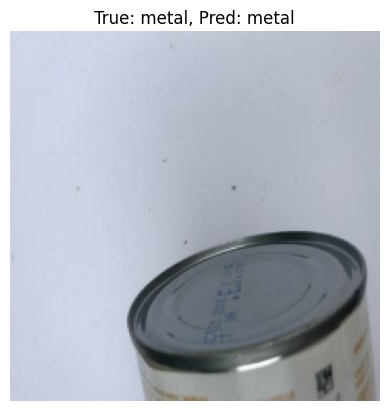

In [26]:
# Extract class names from the training dataset
class_names = train_ds.class_names

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):

    # Generate predictions for the batch of images
    predictions = model.predict(images)

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)

    # Loop through the first 8 images in the batch
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [27]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

# Model Deployment

In [28]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [29]:
def classify_image(img):
    # Resize image to 224x224 pixels (Note: Comment says 128x128, but code resizes to 224x224)
    img = img.resize((224, 224))

    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)

    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]

    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]

    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

In [30]:
iface = gr.Interface(
    fn=classify_image,  # Function to classify image using the trained model
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image
    outputs="text"  # Outputs prediction as text
)

# Launch the interface
iface.launch()  # Start the Gradio interface for user interaction

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8a03d006b6b1fd8154.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
